In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
from sklearn.model_selection import KFold, GridSearchCV

## misc function

In [3]:
def train_test_split(X, y, test_p=0.25, random_state=42):
    ids = np.unique(X.index.values)
    test_size = math.floor(test_p * len(ids))
    test_index = np.random.choice(ids, size=test_size)
    X_train = X[~X.index.isin(test_index)]
    X_test = X[X.index.isin(test_index)]
    y_train = y[~y.index.isin(test_index)]
    y_test = y[y.index.isin(test_index)]
    return X_train, X_test, y_train, y_test

In [4]:
data = pd.read_csv('/projects/eerhan_prj/eerhan_prj_results/pog500_expression/results/04_02_250103127/data/All_FLUOROURACIL.tsv', sep='\t', index_col=0)

In [5]:
data = data.drop_duplicates()

In [6]:
X_columns = data.columns.values[pd.Series(data.columns.values).str.contains('ENSG')]

In [7]:
X = data.loc[:, X_columns]

In [8]:
y = data.loc[:, 'y_trans']
y_discrete = y > 0

In [9]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

## RBF

In [10]:
from sklearn.svm import SVC, SVR

In [11]:
from scipy.stats import spearmanr

In [12]:
print('SVC with linear kernel')
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y_discrete[train_index], y_discrete[test_index]
    svc_rbf = SVC(C=10, kernel='linear', gamma='auto')
    svc_rbf.fit(X_train, y_train)
    print(svc_rbf.score(X_test, y_test))

SVC with linear kernel
0.6842105263157895
0.631578947368421
0.631578947368421
0.5263157894736842
0.631578947368421


In [13]:
print('SVR with RBF')
corrs = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    svr_rbf = SVR(C=10, kernel='linear', gamma='auto')
    svr_rbf.fit(X_train, y_train)
    y_pred = svr_rbf.predict(X_test)
    corrs.append(spearmanr(y_pred, y_test))
    print(svr_rbf.score(X_test, y_test))

SVR with RBF
0.18355986886786235
0.0006921995353103005
0.006884720686349821
-0.1450896334780587
-0.02096730318998108


In [14]:
[(x.correlation, x.pvalue) for x in corrs]

[(0.41127452088151756, 0.0802262532973057),
 (0.27504436149593975, 0.25443153478853003),
 (0.18093985056305348, 0.4585074577973466),
 (0.2154800816403047, 0.37563681063582444),
 (0.22715289982425313, 0.34967330292770626)]

In [15]:
corrs

[SpearmanrResult(correlation=0.41127452088151756, pvalue=0.0802262532973057),
 SpearmanrResult(correlation=0.27504436149593975, pvalue=0.25443153478853003),
 SpearmanrResult(correlation=0.18093985056305348, pvalue=0.4585074577973466),
 SpearmanrResult(correlation=0.2154800816403047, pvalue=0.37563681063582444),
 SpearmanrResult(correlation=0.22715289982425313, pvalue=0.34967330292770626)]

In [16]:
weights = pd.DataFrame(data={'weights': svc_rbf.coef_[0],
                   'names': data.columns[:-3]})

In [17]:
weights['weights'] = np.abs(weights['weights'])

In [18]:
weights.sort_values('weights')

,weights,names
11214,0.000000e+00,ENSG00000232665
18083,2.775558e-17,ENSG00000273858
8263,2.775558e-17,ENSG00000212138
15836,2.775558e-17,ENSG00000259680
6735,5.551115e-17,ENSG00000183704
...,...,...
18794,3.342148e-03,ENSG00000278903
7783,3.596826e-03,ENSG00000202385
4238,3.881342e-03,ENSG00000151650
16504,4.237378e-03,ENSG00000263520


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [20]:
svc_rbf = SVR(C=10, kernel='linear', gamma='auto')
svc_rbf.fit(X_train, y_train)
svc_rbf.score(X_test, y_test)

0.27040664399106173

In [21]:
params = {"C":[0.1, 1, 10, 50], "gamma": [0.1, 0.01, 0.001, 1, 10]}
grid_search = GridSearchCV(svc_rbf, params,cv=5)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=10, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto', kernel='linear',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 50],
                         'gamma': [0.1, 0.01, 0.001, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [22]:
grid_search.score(X_test, y_test)

0.27040664399106173

### PCA/ t-SNE

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [24]:
pca = PCA(n_components=10)

In [25]:
pca_expression = pca.fit_transform(X)

In [26]:
pca_expression_df = pd.DataFrame(pca_expression, columns=['PC{}'.format(i) for i in range(1, 11)], index=X.index)

In [27]:
pca_expression_df['y_trans'] = data['y_trans']
pca_expression_df['y'] = data['y']
pca_expression_df['discrete'] = [1 if x else 0 for x in y_discrete]

In [28]:
tsne = TSNE(n_components=3)

In [29]:
tsne_expression = tsne.fit_transform(pca_expression)

In [30]:
tsne_expression_df = pd.DataFrame(tsne_expression, columns=['tsne{}'.format(i) for i in range(1, 4)], index=X.index)

In [31]:
tsne_expression_df['y_trans'] = data['y_trans']
tsne_expression_df['y'] = data['y']
tsne_expression_df['discrete'] = [1 if x else 0 for x in y_discrete]

## Try to explain with cancer type

In [32]:
from matplotlib import pyplot as plt
import seaborn as sns

In [33]:
drugs_df = pd.read_csv('../data/processed/drugs_filtered.tsv', sep='\t', index_col=0)

In [34]:
cancer_map = drugs_df[['pog_id', 'cancer_cohort']]

In [35]:
data = cancer_map.join(data, on='pog_id', how='right').drop_duplicates().sort_values('pog_id')

In [36]:
data = data.set_index('pog_id')

In [37]:
data

,cancer_cohort,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001561,ENSG00000001631,...,ENSG00000283648,ENSG00000283657,ENSG00000283662,ENSG00000283667,ENSG00000283679,ENSG00000283689,ENSG00000283698,y,y_trans,y_pred
pog_id,,,,,,,,,,,,,,,,,,,,,
POG001,COLO,-0.534357,0.202300,-0.989164,-0.235257,0.321601,-0.451788,-0.818186,0.466604,-0.395610,...,-0.348808,-0.120957,0.006363,0.049503,-0.169005,-0.756265,-0.133704,33,-1.020200,NaN
POG001,COLO,-0.534357,0.202300,-0.989164,-0.235257,0.321601,-0.451788,-0.818186,0.466604,-0.395610,...,-0.348808,-0.120957,0.006363,0.049503,-0.169005,-0.756265,-0.133704,6,-2.255413,NaN
POG069,CHOL,-0.205779,-0.384483,3.745577,-0.477753,3.800310,-0.597806,-0.457818,1.735611,-0.089142,...,-0.348808,-0.120957,-0.474758,-0.020600,-0.169005,-0.039147,-0.133704,42,-0.827058,NaN
POG089,COLO,0.614554,-0.684453,-0.863048,-0.337074,-0.912991,-0.737476,-0.328798,0.373476,-0.719344,...,-0.348808,-0.120957,-0.363730,-0.721630,-0.169005,-0.756265,-0.133704,420,1.283477,NaN
POG118,COLO,1.074395,0.200985,-0.682883,-0.570576,0.167511,-0.854925,-0.216090,0.305033,-0.806393,...,-0.348808,-0.120957,-0.067656,-0.546373,-0.169005,-0.756265,-0.133704,709,1.838307,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
POG905,COLO,0.392819,-0.348083,-0.279313,0.011093,-0.634694,-0.166100,-0.221281,0.682032,-0.144537,...,-0.348808,-0.120957,-0.104665,0.329914,-0.169005,0.160978,-0.133704,93,-0.154915,True
POG914,PANC,-0.117252,-0.531398,-0.439660,-0.185474,0.159106,1.541679,-0.099675,-0.778841,3.479124,...,-0.024203,-0.120957,-0.363730,0.785584,-0.169005,2.946064,-0.133704,181,0.452617,NaN
POG916,PANC,-0.051204,-1.042312,0.556653,0.194169,0.224477,-0.572412,-0.350301,-0.457943,-0.543089,...,-0.024203,-0.120957,-0.474758,0.084554,-0.169005,-0.756265,-0.133704,211,0.598613,True


In [38]:
data['y_true'] = data['y_trans'] > 0

In [39]:
# data.to_csv('../ismb_poster/gemcitabine.tsv', sep='\t')

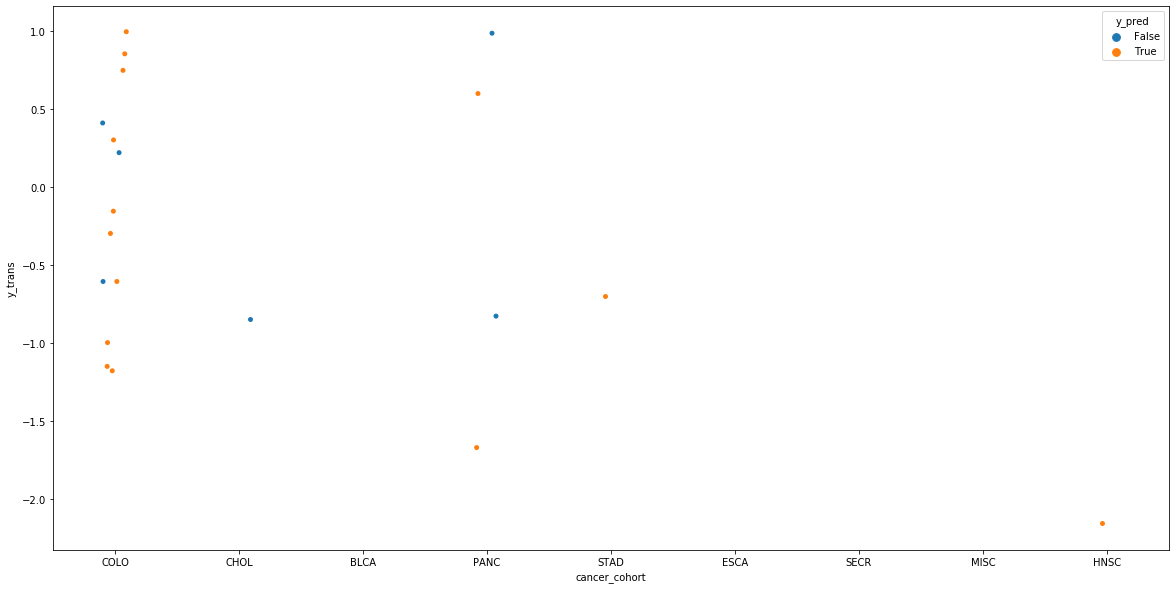

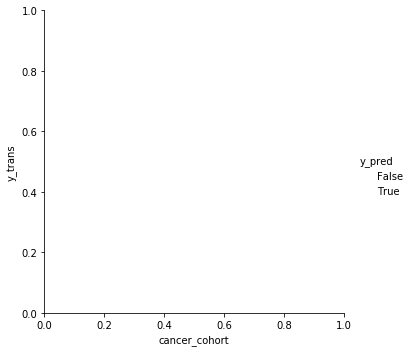

In [40]:
fig, ax = plt.subplots(figsize=(20,10))
sns.catplot(data=data, ax=ax, x='cancer_cohort', y='y_trans', hue='y_pred')

## Try COLO 5-FU

In [52]:
brca_data = data[data['cancer_cohort'] == 'COLO']

In [53]:
data = brca_data

In [54]:
X_columns = data.columns.values[pd.Series(data.columns.values).str.contains('ENSG')]

In [55]:
X = data.loc[:, X_columns]

In [56]:
y = data.loc[:, 'y_trans']
y_discrete = y > 0

In [57]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

## RBF

In [58]:
from sklearn.svm import SVC, SVR

In [59]:
from scipy.stats import spearmanr

In [60]:
print('SVC with linear kernel')
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y_discrete[train_index], y_discrete[test_index]
    svc_rbf = SVC(C=1, kernel='linear', gamma='auto')
    svc_rbf.fit(X_train, y_train)
    print(svc_rbf.score(X_test, y_test))

SVC with linear kernel
0.5
0.42857142857142855
0.5714285714285714
0.3076923076923077
0.5384615384615384


In [61]:
print('SVR with linear kernel')
corrs = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    svr_rbf = SVR(C=10, kernel='linear', gamma='auto')
    svr_rbf.fit(X_train, y_train)
    y_pred = svr_rbf.predict(X_test)
    corrs.append(spearmanr(y_pred, y_test))
    print(svr_rbf.score(X_test, y_test))

SVR with linear kernel
0.11974415228114776
-0.5400082970796451
-0.6068152168278211
-0.3811023211975817
-0.0075683308062530754


In [62]:
[(x.correlation, x.pvalue) for x in corrs]

[(0.3946940163235586, 0.16253261438999686),
 (0.3149787376504485, 0.27269091395629946),
 (0.2907496039850294, 0.3132316295658608),
 (-0.18232322463624387, 0.5510611888813317),
 (0.28965765225210904, 0.33708489875679337)]

In [63]:
corrs

[SpearmanrResult(correlation=0.3946940163235586, pvalue=0.16253261438999686),
 SpearmanrResult(correlation=0.3149787376504485, pvalue=0.27269091395629946),
 SpearmanrResult(correlation=0.2907496039850294, pvalue=0.3132316295658608),
 SpearmanrResult(correlation=-0.18232322463624387, pvalue=0.5510611888813317),
 SpearmanrResult(correlation=0.28965765225210904, pvalue=0.33708489875679337)]

### Visualize

In [41]:
sns.set(rc={'figure.figsize':(10,10)})

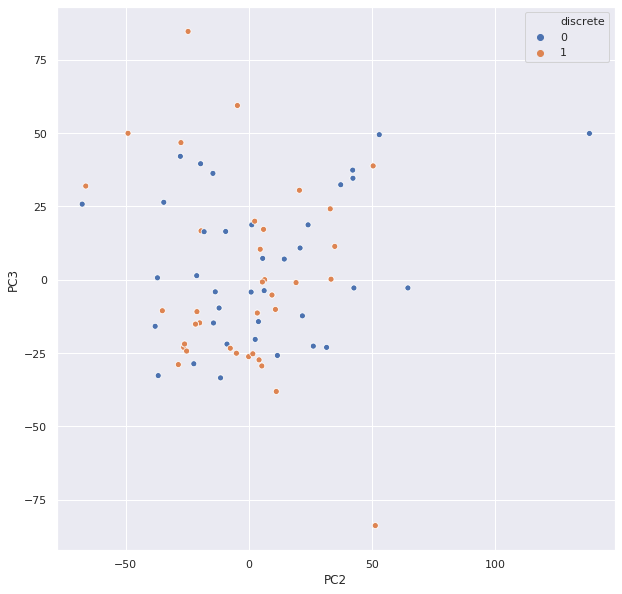

In [42]:
sns.scatterplot(data=pca_expression_df, x='PC2', y='PC3', hue='discrete')
plt.show()

In [43]:
visualize = pca_expression_df.loc[:, ['PC{}'.format(i) for i in range(1, 5)]+['discrete']]

In [44]:
visualize

,PC1,PC2,PC3,PC4,discrete
pog_id,,,,,
POG001,56.410982,-21.151061,1.393517,121.129201,0
POG001,56.410982,-21.151061,1.393517,121.129201,0
POG069,-32.282407,21.767047,-12.314388,30.061630,0
POG089,22.015337,-19.960692,-14.704760,-1.651689,1
POG118,14.473693,-26.437911,-23.054655,-12.918506,0
...,...,...,...,...,...
POG905,-4.105426,31.592215,-23.065812,-10.641877,0
POG914,-28.938992,33.077715,24.188226,17.458020,1
POG916,-21.441971,-4.635182,59.448367,-26.175175,1


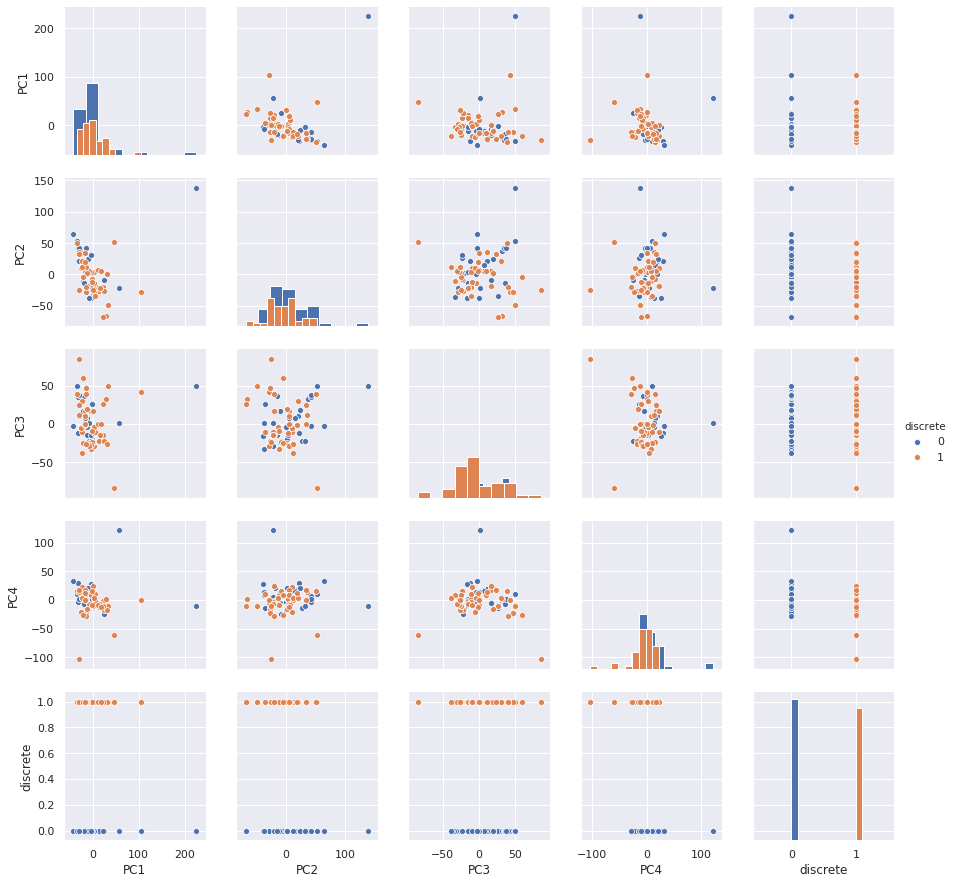

In [45]:
sns.pairplot(visualize, hue='discrete', diag_kind='hist')
plt.show()

In [46]:
pca.explained_variance_ratio_

array([0.0779963 , 0.06342384, 0.05611487, 0.04475428, 0.04038227,
       0.03702375, 0.03255134, 0.02818591, 0.0271333 , 0.02257165])

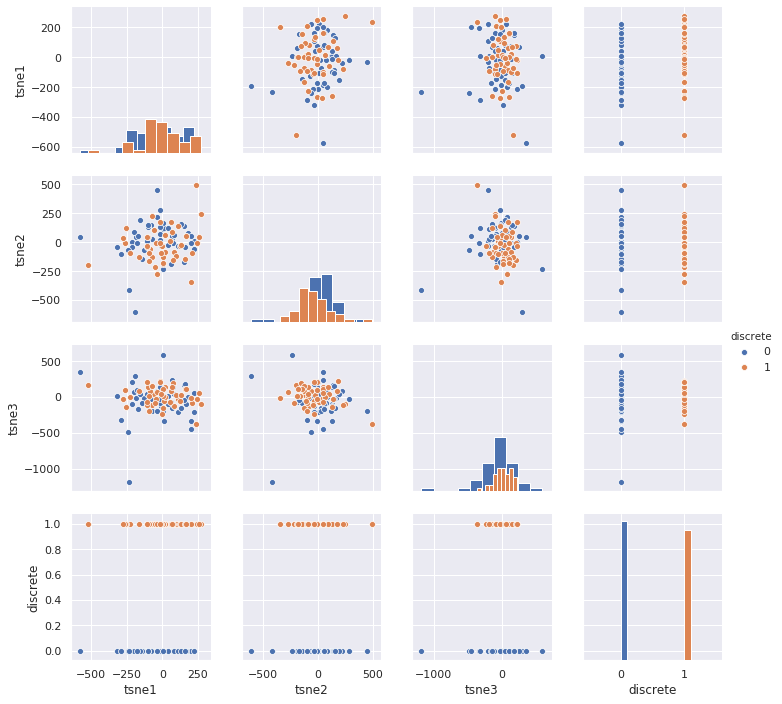

In [47]:
sns.pairplot(tsne_expression_df.loc[:,['tsne{}'.format(i) for i in range(1, 4)]+['discrete']] , hue='discrete', diag_kind='hist')
plt.show()